# 3.A Explore -- Lyrical Insights and Data

With our new features in place across data sets we'll now take the time to explore some of the lyrical data we have on hand. In particular, we are seeking to answer the following questions:

 - **Who are the smartest rappers?**
 - **Who are the most technical rappers?**
 - **What are the most lyrically complex songs? Lyrically simple songs?**
 - **Who's the biggest buzzkill? Who's the happiest rapper?**
 - **How has the genre changed over time?**
 - **What are the topics that rappers talk about? And has this changed over time**?

For the most part, we will rely on previously engineered features to answer these questions. However, in the last portion of this notebook, we'll be leveraging **LDA** to extract topics from our lyrics. More information on this process can be found in it's respective section. Much of the theory and processes leveraged for this particular section was inspired or modified from the below articles from TDS and MachineLearningPlus:

 - https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
  - https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

### Setup

In [1]:
import pandas as pd
from bs4 import BeautifulSoup
import numpy as np
import time
import requests
import seaborn as sns
import warnings
import matplotlib.pyplot as plt
import lyricsgenius
import re
import sys
import spotipy
import spotipy.util as util
from sklearn.compose import ColumnTransformer, make_column_transformer
from pyjarowinkler import distance

import nltk
from nltk.stem import PorterStemmer
from sklearn.model_selection import cross_val_score

from math import sin
from random import random
import bokeh
from bokeh.io import output_file, show
from bokeh.models import ColumnDataSource, HoverTool, LinearColorMapper
from bokeh.palettes import plasma
from bokeh.plotting import figure
from bokeh.transform import transform
from bokeh.transform import jitter
from bokeh.plotting import figure, show
from bokeh.io import output_notebook


from pprint import pprint

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel

# spacy for lemmatization
import spacy

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
songs = pd.read_csv('cleaned_lyrics_and_audio_features.csv')

In [3]:
songs = songs.dropna()

In [4]:
songs.columns

Index(['album', 'artist', 'date', 'features', 'lyrics', 'producers', 'song',
       'artist_clean', 'album_name_clean', 'track_clean', 'acousticness',
       'album_id', 'album_name', 'artist_id', 'danceability', 'duration_ms',
       'energy', 'id', 'instrumentalness', 'key', 'liveness', 'loudness',
       'mode', 'preview_url', 'speechiness', 'tempo_x', 'time_signature',
       'track_href', 'track_id', 'track_name', 'uri', 'valence', 'genres',
       'pop', 'follower', 'cleaned_lyrics', 'split_lyrics', 'number_lines',
       'track_unique_words_pct', 'track_unique_words', 'track_complexity',
       'track_total_words', 'artist_vocab_size', 'artist_vocab_complexity',
       'track_rhyme_density', 'cleaned_lyrics_for_sentiment',
       'sentiment_track_neg', 'sentiment_track_pos', 'sentiment_track_neu',
       'sentiment_track_comp', 'track_sad_words', 'track_angry_words',
       'track_joy_words', 'track_ant_words', 'track_trust_words',
       'track_fear_words', 'track_disgust_words

## Who are the smartest rappers?

To dig into this question, we'll be using **vocabulary features**. To vizualize this, we'll leverage **Bokeh** to create an interactive scatterplot. 

In [5]:
#etract and store the features that we care about
artist_complexity_df = songs[['artist_clean', 'artist_vocab_complexity', 'artist_vocab_size']].drop_duplicates()

In [6]:
#set Bokeh up such that the visuals are output inline
output_notebook()

Loading BokehJS ...

In [7]:
#Set up our scatterpot figure
#Our data source will be the DF we temporarily made
source = ColumnDataSource(artist_complexity_df)

#Set the title and width
p = figure(title='Artist Vocab Size and Complexity',plot_width=1000)

#Set up our data sources to feed into the figure
p.circle(x='artist_vocab_size', y='artist_vocab_complexity',
         source=source, fill_alpha=0.4,
         size=10, color='blue');

#Incorporate a hover tool
hover = HoverTool()
hover.tooltips=[
    ('Artist', '@artist_clean'),
    ('Artist Vocab Size', '@artist_vocab_size'),
    ('Vocab Complexity Score', '@artist_vocab_complexity')
]

p.add_tools(hover)

#Add in some additional labeling
p.title.text_font_size = '15pt'
p.yaxis.axis_label = 'Vocab Complexity'
p.xaxis.axis_label = 'Vocab Size'
show(p)


In [10]:
#Pull in the relevant libraries for wordclouds
import wordcloud
from wordcloud import WordCloud

In [11]:
#Which artists are showing the highest vocabulary complexity?
artist_complexity_df[['artist_clean','artist_vocab_complexity']].sort_values(by='artist_vocab_complexity', ascending=False).head(10)

,artist_clean,artist_vocab_complexity
13563,loonie,0.420962
1650,bewhy,0.316637
23563,wc no beat,0.316547
936,amill leonardo,0.315754
3737,ceza,0.301329
11015,k.a.a.n.,0.301186
1618,becky g,0.253669
20355,solillaquists of sound,0.244256
1521,bahamadia,0.243795
6135,doseone,0.243747


In [12]:
#Which artists are showing the loewst vocabulary complexity?
artist_complexity_df[['artist_clean','artist_vocab_complexity']].sort_values(by='artist_vocab_complexity', ascending=False).tail(10)

,artist_clean,artist_vocab_complexity
7171,fatman scoop,0.044776
7100,fat pat,0.044248
15355,mitchy slick,0.042373
1340,asian da brat,0.038567
15113,mike jones,0.037975
7205,fetty wap,0.035363
16335,nle choppa,0.034483
19423,scrilla,0.032520
12921,lil mosey,0.028571
14772,mc mong,0.000000


## Who are the most skilled rappers?

Here we'll focus on our **rhyme density** feature which is a proxy for internal rhyme detection in our lyrical data. This is often thought of as an indication of MC skills.

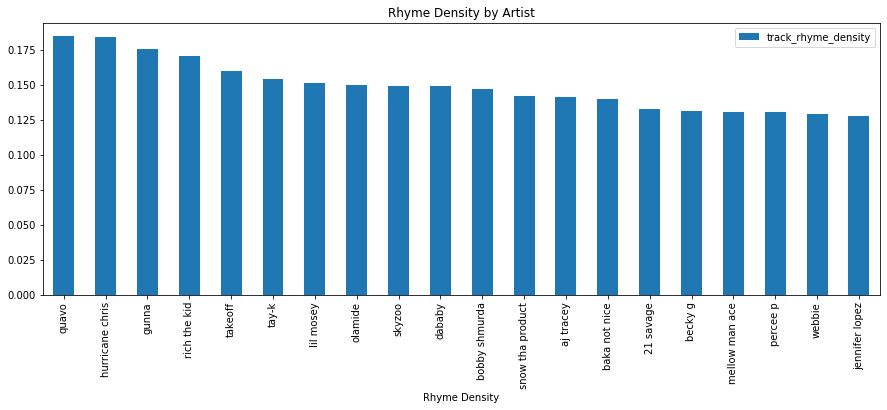

In [156]:
#Build a chart of rhyme density by artist. Isolate to the top entries
songs[['artist_clean', 'track_rhyme_density']].groupby('artist_clean').apply(np.mean).sort_values(by='track_rhyme_density', ascending=False).head(20).plot(kind='bar', figsize=(15,5));
plt.title('Rhyme Density by Artist');
plt.xlabel('Rhyme Density');

In [161]:
#Build a chart of rhyme density by artist. Isolate to the top entries
artist_complexity_df.sort_values(by='artist_vocab_size', ascending=False).describe()

,artist_vocab_complexity,artist_vocab_size
count,778.000000,778.000000
mean,0.103204,949.012853
std,0.040088,328.344417
min,0.000000,9.000000
25%,0.077280,734.750000
50%,0.096488,947.500000
75%,0.118199,1162.750000
max,0.420962,2031.000000


In [165]:
#Build a list to filter for artists with high vocab size
top25perc_artist_vocab = artist_complexity_df[artist_complexity_df.artist_vocab_size > 1162]['artist_clean'].values

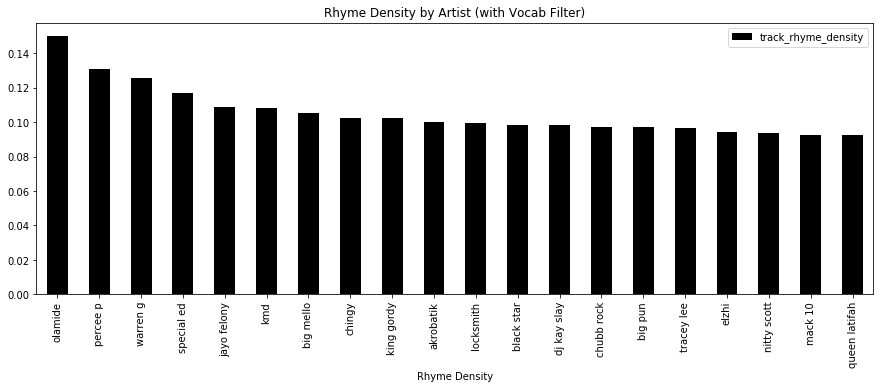

In [178]:
#Use that list to filter our original visual or high rhyme density users with strong vocabularies.
density_df =songs[['artist_clean', 'track_rhyme_density']].groupby('artist_clean').apply(np.mean).sort_values(by='track_rhyme_density', ascending=False)
density_df[density_df.index.isin(top25perc_artist_vocab)].sort_values(by='track_rhyme_density', ascending=False).head(20).plot(kind='bar', figsize=(15,5), color='black');

plt.title('Rhyme Density by Artist (with Vocab Filter)');
plt.xlabel('Rhyme Density');


## What is the most lyrically complex song of all time?

In [13]:
#Sort by track complexity
songs.sort_values(by='track_complexity', ascending=False).head(7)

,album,artist,date,features,lyrics,producers,song,artist_clean,album_name_clean,track_clean,...,track_disgust_words,track_surprise_words,librosa_id,tempo_y,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc
1532,Kollage,Bahamadia,1996.0,[],Bahamadia...\nBahamadia...Bahamadia...\nBahama...,['DJ Premier'],Intro,bahamadia,kollage,intro,...,0,0,6ZcRUVs3I5U8EOnm9ZdCsO_4ioG1W3KU4WBhYlwEBp7BA_...,0.0,0.180452,1095.757274,1419.522445,2098.478977,0.051234,0.761194
16371,Metaphorical Music,Nujabes,2003.0,[],"Nujabes - ""KumomiÃ¢â¬Â\n[Emcee(s): n/a]\n[Pr...",['Nujabes'],Kumomi,nujabes,metaphorical music,kumomi,...,0,0,3Rq3YOF9YG9YfCWD4D56RZ_5FrjDW96mCYw9ECc74c637_...,0.0,0.363613,1345.772662,1898.447253,2869.365983,0.046815,5.104712
4773,Maze Garden,Crucial Star,2018.0,['Kim EZ (Ggotjam Project)'],Singer songwriter\nÃ¬âÂ´Ã«Â¦Â°Ã¬â¹ÅÃ¬Â ËÃ...,[],Singer Songwriter,crucial star,maze garden,singer songwriter,...,0,0,4vdAgNz4vrUZVvS0CaVvGJ_2zoYQaGw1afawZD4nAoAjk_...,0.0,0.335465,2099.422878,2470.433859,4570.814028,0.076607,8.297643
8570,Guerilla City,Guerilla Black,0.0,[],"56x\n\nHabalga, hagurerilla nasty holla",[],Guerilla Nasty,guerilla black,guerilla city,guerilla nasty,...,0,0,2eTcJVakGgCvZQMnw9Evbn_5YfeTtMevDZsud8ggbTiP6_...,0.0,0.395675,2210.982678,2264.742129,4485.847875,0.093370,1.944053
9249,The 3rd World,Immortal Technique,2008.0,"['Veneno (rapero)', 'Temperamento']","[Intro]\nLamentablemente, las condiciones que ...",['Southpaw'],Golpe de Estado,immortal technique,the 3rd world,golpe de estado,...,4,0,7h8ja4JSORo2sXJPmCXRxa_5FF1UrCmFwGQOS3kZNcqTQ_...,0.0,0.478319,2780.958493,2771.489677,6033.121852,0.098092,9.633583
9245,Revolutionary Vol. 1,Immortal Technique,2001.0,[],[Intro]\nYou have to speak the truth\nYou have...,['Immortal Technique'],Speak Your Mind,immortal technique,revolutionary vol. 1,speak your mind,...,6,4,7h8ja4JSORo2sXJPmCXRxa_1lOegkmEfMEMhHy0loZKXV_...,0.0,0.278684,2699.341330,2392.513469,5231.543366,0.137322,-4.861271
2199,ELEVATORS: ACT I & II,Bishop Nehru,2018.0,[],"[Intro]\nWelcome to Elevators; an MF DOOM, KAY...",['KAYTRANADA'],Act I: Ascension,bishop nehru,elevators: act i and ii,act i ascension,...,0,0,1b5fazYV5ecKkQHKTlwLG8_6Vy4IwMH5C24rOVEcSSqhH_...,0.0,0.396140,1837.396298,2040.462578,3410.637710,0.088962,-17.490236


In [14]:
#Save our example track
imm_tech_str = songs[songs.track_clean == 'speak your mind']['cleaned_lyrics'][9245]

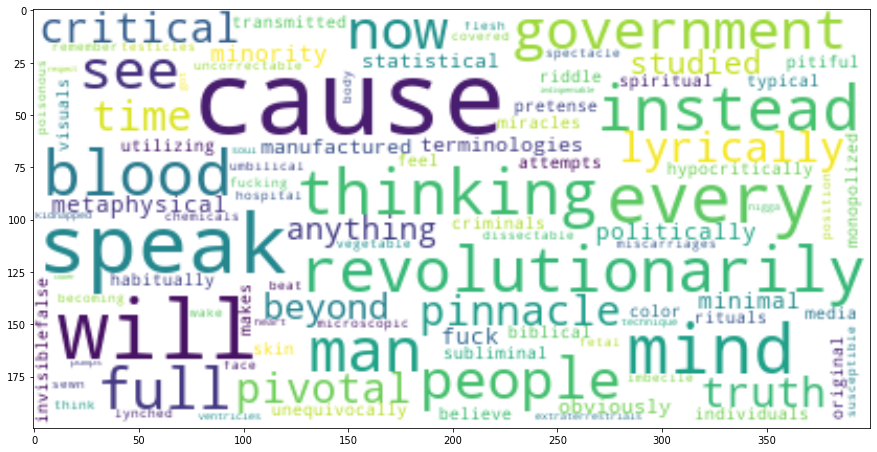

In [15]:
#Build a word cloud for the track
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words=100,max_font_size=50, background_color="white").generate(imm_tech_str)
plt.imshow(wordcloud, interpolation='bilinear');

## What is the least impressive song of all time?

In [16]:
#Let's grab one of the least complex tracks and save it
garbage = songs.sort_values(by='track_complexity', ascending=True).head(7)['cleaned_lyrics'][10703]

In [139]:
#What does this song look like lyrically
songs.sort_values(by='track_complexity', ascending=True).head(7)['cleaned_lyrics'][10703]

'whoa i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care little care i do not care i dont care about the cars i dont care about your flash i dont care about your phone i dont c i dont care about the beats i dont care about your plays i dont care about the bass i dont care i dont care about your bank i dont care about your fees give a fuck bout your degrees i dont care give a fuck about your life i dont care nah i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not care i do not give a fuck about it man now i do not care i get around to it i do not care one two'

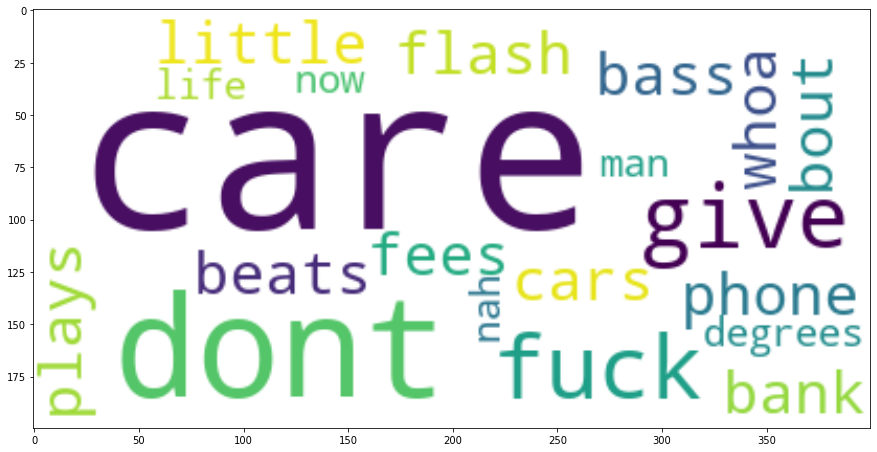

In [17]:
#convert into a wordcloud
plt.figure(figsize=(15,15))
wordcloud = WordCloud(max_words=20, background_color="white").generate(garbage)
plt.imshow(wordcloud, interpolation='bilinear');

## Biggest Buzzkill?

In [185]:
#Check for high negative sentiment tracks for presentation
songs[songs.number_lines > 40].sort_values(by='sentiment_track_neg', ascending=False).head()

,album,artist,date,features,lyrics,producers,song,artist_clean,album_name_clean,track_clean,...,track_surprise_words,librosa_id,tempo_y,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc,cleaned_lyrics_for_topics
19146,Ã¬ââÃ¬Â¹ËÃªÂ¸Â° Ã¬â ÅÃ«â¦â (The Boy ...,San E,0.0,[],[Hook]\nÃ¬â¢ËÃ«â¦â¢ haters warup\nÃ¬Å¾Â Ãª...,['Eardrummer JBo'],#LuvUHater,san e,Ã¬ââÃ¬Â¹ËÃªÂ¸Â° Ã¬â ÅÃ«â¦â,luvuhater,...,0,61MMiylth1injW39oZBuYB_5ZbAdk06jiZEkrVDclHOfc_...,0.0,0.453389,1957.726337,2308.795104,4181.966379,0.064468,8.525144,haters warup blah blah blah you just ding than...
23077,Sinatra 2.5,Vado,2017.0,['Coko'],[Verse 1]\nI hate that the world is in dangers...,['Lee On The Beats'],Hate,vado,sinatra 2.5,hate,...,6,4ubKsFJjMgWkARG6w2Qlv8_6WjKkNGUoCWsR39ZiPB1GA_...,0.0,0.464538,1929.575149,2346.228341,4112.200134,0.070156,3.408737,i hate that the world is in dangers i hate tha...
12007,DIRT,KOHH,2015.0,"['Loota', 'DUTCH MONTANA']",[Intro: Kohh]\nDirt!\nAyy...\nÃ¦Â±Å¡Ã£âÅÃ£Â...,['Loota'],Dirt boys,kohh,dirt,dirt boys,...,0,3MUcTGmdb4on8WHhIhPkzK_0KYwjhv3SYVG2DgfK3qXuM_...,0.0,0.383193,2749.139798,2721.071819,5903.305970,0.117544,1.004684,dirt ayy dirt boys we dirt dirt dirt dirt ohh ...
7777,Purple Reign,Future,2016.0,[],[Intro]\n(DJ Esco Moe City the coolest DJ on t...,"['Metro Boomin', 'Southside']",Wicked,future,purple reign,wicked,...,2,1RyvyyTE3xzB2ZywiAwp0i_3jJKDKdlwRS584zUlHV2Ly_...,0.0,0.595563,2130.572759,2527.749934,4833.820771,0.033755,10.218429,wicked tunes you know what i am sayin wizard w...
20352,AinÃ¢â¬â¢t No Stoppin Me,Snootie Wild,2015.0,['Boosie Badazz'],"[Hook: Boosie Badazz]\nHo you hating, you hati...",['Big Wayne'],They Hatin,snootie wild,aint no stoppin me,they hatin,...,1,1YXg2Chm7UfZAUAkjJEpqK_0IvJmzLpMVaGskAA20yXtQ_...,0.0,0.467176,2961.776785,2731.061155,6151.229471,0.136000,4.399868,you hating you hating you hating you know what...


## Happiest Song?

In [184]:
#Check for high pos sentiment tracks for presentation
songs[songs.number_lines > 40].sort_values(by='sentiment_track_pos', ascending=False).head()

,album,artist,date,features,lyrics,producers,song,artist_clean,album_name_clean,track_clean,...,track_surprise_words,librosa_id,tempo_y,chroma_stft,spec_cent,spec_bw,rolloff,zcr,mfcc,cleaned_lyrics_for_topics
4759,Midnight,Crucial Star,0.0,[],"[Hook 1]\nÃ«âÅ Ã«Â°âºÃªÂ³Â Ã¬Å¾ËÃ¬âÂ´,...","['Crucial Star', 'BigPie']",Blessing,crucial star,midnight,blessing,...,0,4vdAgNz4vrUZVvS0CaVvGJ_5XzQZiSyVyn4bxLGN1ZvER_...,0.0,0.391282,2640.345672,2620.325324,5613.807721,0.120493,4.819228,your love your love your love blessing blessin...
19982,Simon Dominic Presents `SNL LEAGUE BEGINS`,Simon Dominic,2012.0,['Zion.T'],"[Intro: Simon Dominic, Zion.T]\nYeah, yea\nSim...",['Loptimist'],Stay Cool,simon dominic,simon dominic presents `snl league begins`,stay cool,...,32,57W9ikVc6O2wLDtmclSjvN_74GSC7pvqqKduKOtFAdxjJ_...,0.0,0.408398,2139.664200,2473.547801,4620.622060,0.089018,3.780503,yeah simon d zion t ouu yeah stay cool stay co...
119,Slaughter King,21 Savage,2015.0,[],"[Hook: 21 Savage]\nWow, Wow\nWow, Wow\nWow, Wo...",['Sonny Digital'],Wow,21 savage,slaughter king,wow,...,3,1URnnhqYAYcrqrcwql10ft_1HSyuTHvLXMWyPJQGnQTLw_...,0.0,0.545858,2187.062989,2318.201667,4619.863731,0.070933,4.157024,wow wow wow wow wow wow wow wow wow wow wow wo...
15072,Wave[s],Mick Jenkins,2015.0,[],[Intro]\nDo you feel it?\nI know you feel that...,['KAYTRANADA'],Your Love,mick jenkins,wave,your love,...,3,1FvjvACFvko2Z91IvDljrx_2gSh19Qplm8gsM7Tp8IeOu_...,0.0,0.404699,2387.251740,2585.105840,5193.035265,0.098180,5.541177,do you feel it i know you feel that girl had t...
21915,Kiss Land (Deluxe),The Weeknd,2014.0,[],[Verse 1: The Weeknd]\nIs it so hard to say th...,"['DaHeala', 'Danny Boy Styles', 'The Weeknd']",Wanderlust,the weeknd,kiss land,wanderlust,...,48,1Xyo4u8uXC1ZmMpatF05PJ_6wRev1uYL0JsMsWqktJuVi_...,0.0,0.386722,2031.836944,2187.292569,4167.949797,0.095767,5.296803,is it so hard to say the same thing and you ar...


## Has hip hop gotten simpler?

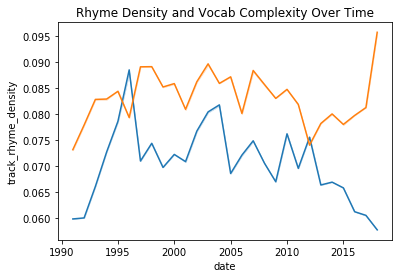

In [193]:
#Plot rhyme density and vocab complexity over time. Exclude records with no date information (these are listed with date==0)
sns.lineplot(songs[(songs.date>1990) & (songs.date<2019)]['date'], songs.track_complexity, ci=False);
sns.lineplot(songs[(songs.date>1990) & (songs.date<2019)]['date'], songs.track_rhyme_density, ci=False);
plt.title('Rhyme Density and Vocab Complexity Over Time');


***
## Topics

In [21]:
#Process followed based on exellent article at the below link
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

## Preparation

In [5]:
#Prepare bad word list
bad_words = pd.read_csv('lyricsclean/bad-words.csv', header=None)

In [6]:
#Adjust the list
bwlist = bad_words.rename(columns={0:'words'})['words'].to_list()

In [7]:
#Build a function to get ride of some words that may or may not throw off our processes
def strip_words(phrase):
    
    #Based on manual searching these are some terms and ad libs that we want to consider dorpping
    list_to_remove = ['niggas', 'nigga', 'bros', 'hoes', 'hoe', 'fucking', 'fuck', 'shits', 'shit', 'bitches', 'bitch', 'asshole', 'cocksucker', 'cunt', 'faggot', 'hoes', 'thots', 'thot',  'pussies', 'pussy']
    list_of_adlibs = [' ay ', ' aye ', ' yay ', ' yea ', ' woo ', ' huh', ' uhh ', ' bam ', ' sheesh ']
    
    #Add our add'l lists together
    list_to_remove.extend(list_of_adlibs)
    list_to_remove.extend(bwlist)
    
    #replace the word with a space
    for word in list_to_remove:
        phrase = re.sub(word, ' ', phrase)
    
    #remove all multiple spaces in strings and trim
    phrase = re.sub(r"\s\s+", " ", phrase)
    phrase = phrase.strip()

    return phrase

In [8]:
#We'll also look at stopwords for removal
from nltk.corpus import stopwords
stop = stopwords.words('english')

In [9]:
#strip out the words we want to remove
songs['cleaned_lyrics_for_topics'] = songs['cleaned_lyrics'].apply(strip_words)

In [27]:
#After testing, we determine that stop words are needed for interpretability of topics
# songs['cleaned_lyrics_for_topics'] = songs['cleaned_lyrics_for_topics'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stop)]))

In [10]:
#Lemmatize our text and prepare list of our docs
from nltk.stem.wordnet import WordNetLemmatizer
lemmatizer = WordNetLemmatizer()
topic_docs = list(songs['cleaned_lyrics_for_topics'].str.split())

In [11]:
#generate bigram and trigram models
bigram = gensim.models.Phrases(topic_docs, min_count=5, threshold=100)
trigram = gensim.models.Phrases(bigram[topic_docs], threshold=100)  

#Instantiate Phrasers
bigram_mod = gensim.models.phrases.Phraser(bigram)
trigram_mod = gensim.models.phrases.Phraser(trigram)

In [12]:
#Functions replicated from:
#https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/

def make_bigrams(texts):
    return [bigram_mod[doc] for doc in texts]

def make_trigrams(texts):
    return [trigram_mod[bigram_mod[doc]] for doc in texts]

def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    texts_out = []
    for sent in texts:
        doc = nlp(" ".join(sent)) 
        texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    return texts_out

In [13]:
# turn topic docs into bygrams
data_words_bigrams = make_bigrams(topic_docs)

nlp = spacy.load('en_core_web_sm', disable=['parser', 'ner'])

# Lemmatize and only keep nouns, adjectives, verbs, adverbs
data_lemmatized = lemmatization(data_words_bigrams, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV'])

In [14]:
#What does our data look like at this point
print(data_lemmatized[1300:1301])

[['waste', 'time', 'nut', 'bolt', 'pen', 'dime', 'dream', 'lisp', 'hear', 'call', 'hammersmith', 'punk', 'rock', 'bed', 'dream', 't', 'lick', 'hear', 'call', 'now', 'know', 'pretty', 'tiger', 'need', 'electric', 'friend', 'maybe', 'pull', 'heist', 'together', 'stay', 'out', 'late', 'bone', 'turn', 'dim', 'shark', 'swim', 'learn', 'man', 'well', 'artist', 'just', 'know', 'trick', 'just', 'trick', 'steal', 'right', 'friend', 'let', 'go', 'start', 'band', 'name', 'so', 'e', 'one', 'understand', 'cir', 'navigate', 'globe', 'plane', 'e', 'aluminum', 'can', 'bust', 'out', 'place', 'together', 'jetplane', 'wave', 'goodbye', 'never', 'forget', 'one', 'catch', 'live', 'dream', 'pirate', 'theive', 'smuggler', 'spy', 't', 'ught', 'control', 'know', 'never', 'need', 'tell', 'so', 'always', 'somewhere', 'halfway', 'hand', 'seem', 'so', 'close', 't', 'ught', 'control', 'know', 'never', 'need', 'tell', 'so', 'always', 'somewhere', 'halfway', 'hand', 'seem', 'so', 'close', 't', 'ught', 'control', 'kno

## Building Our Model

In [15]:
## Preparation# Create Dictionary
id2word = corpora.Dictionary(data_lemmatized)

# Create Corpus
texts = data_lemmatized

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

## Finding Optimal # Topics

In [101]:
#
topic_param = [8,10,15,20,25]
topicnums = []
perps = []
coheres = []

def LDA_compare(num_topics,passes=50, alpha='auto' ):
    # Build LDA model
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=num_topics, 
 ## Building Our Model                                              random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=passes,
                                               alpha='auto',
                                               per_word_topics=True)
    # Print the Keyword in the 10 topics
    #pprint(lda_model.print_topics())
    #doc_lda = lda_model[corpus]

    # Compute Perplexity
    perp = lda_model.log_perplexity(corpus)

    # Compute Coherence Score
    coherence_model_lda = CoherenceModel(model=lda_model, texts=data_lemmatized, dictionary=id2word, coherence='c_v')
    cohere =  coherence_model_lda.get_coherence()
    
    
    perps.append(perp)
    coheres.append(cohere)
    topicnums.append(num_topics)

for number in topic_param:
    LDA_compare(number)
    
    

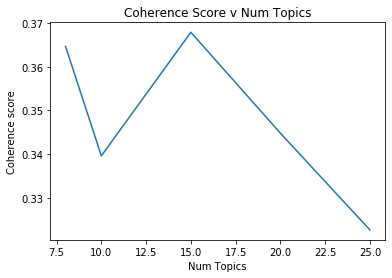

In [102]:
plt.plot(pd.DataFrame(zip(topicnums,perps,coheres))[0],(pd.DataFrame(zip(topicnums,perps,coheres))[2]) );
plt.title('Coherence Score v Num Topics');
plt.xlabel("Num Topics");
plt.ylabel("Coherence score");


## Topic Exploration

In [17]:
lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                               id2word=id2word,
                                               num_topics=10, 
                                               random_state=100,
                                               update_every=1,
                                               chunksize=100,
                                               passes=50,
                                               alpha=0.5,
                                               per_word_topics=True)
## Finding Optimal # Topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]


[(0,
  '0.032*"know" + 0.026*"just" + 0.023*"never" + 0.022*"time" + 0.021*"when" + '
  '0.019*"say" + 0.019*"see" + 0.017*"feel" + 0.017*"so" + 0.016*"life"'),
 (1,
  '0.075*"love" + 0.062*"know" + 0.057*"baby" + 0.045*"want" + 0.043*"girl" + '
  '0.035*"get" + 0.025*"so" + 0.024*"just" + 0.022*"say" + 0.022*"good"'),
 (2,
  '0.064*"so" + 0.059*"e" + 0.054*"man" + 0.035*"more" + 0.025*"look" + '
  '0.024*"make" + 0.016*"work" + 0.016*"need" + 0.014*"little" + 0.011*"g"'),
 (3,
  '0.143*"go" + 0.076*"let" + 0.064*"now" + 0.054*"come" + 0.041*"right" + '
  '0.036*"here" + 0.034*"make" + 0.024*"way" + 0.022*"put" + 0.022*"get"'),
 (4,
  '0.015*"life" + 0.013*"world" + 0.012*"people" + 0.011*"live" + 0.009*"s" + '
  '0.009*"mind" + 0.008*"when" + 0.007*"soul" + 0.006*"eye" + 0.006*"word"'),
 (5,
  '0.097*"get" + 0.037*"money" + 0.019*"gon" + 0.015*"know" + 0.013*"bout" + '
  '0.012*"young" + 0.012*"boy" + 0.012*"just" + 0.011*"talk" + 0.010*"keep"'),
 (6,
  '0.037*"smoke" + 0.037*"roll" +

In [50]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
5      0.162912  0.042136       1        1  17.902803
1      0.174582 -0.067126       2        1  14.795777
7      0.036720  0.041919       3        1  14.298556
4      0.055813  0.165350       4        1  12.300710
2      0.180706 -0.001499       5        1  12.273449
6      0.092371 -0.123544       6        1   9.887624
0      0.100552 -0.213501       7        1   8.823540
9     -0.092619  0.318492       8        1   5.398446
3     -0.349783 -0.162946       9        1   2.543721
8     -0.361255  0.000719      10        1   1.775366, topic_info=      Category           Freq      Term          Total  loglift  logprob
776    Default   32745.000000        be   32745.000000  30.0000  30.0000
269    Default   36821.000000      love   36821.000000  29.0000  29.0000
23     Default  148923.000000       get  148923.000000  28.0000  28.0000
93     Default   76450.000000        go   76450.000000  27.0000  27.0000
31     Default   69550.000000      know   69550.000000  26.0000  26.0000
...        ...            ...       ...            ...      ...      ...
13252  Topic10     140.788910       flu     141.754227   4.0243  -6.2322
23865  Topic10     136.578308       dat     137.542099   4.0241  -6.2625
1494   Topic10    2123.887939       ill    2426.401123   3.8980  -3.5184
806    Topic10    1751.260132     would    2092.735107   3.8530  -3.7113
505    Topic10     285.579041  probably    3064.962891   1.6579  -5.5249

[638 rows x 6 columns], token_table=      Topic      Freq       Term
term                            
4871      1  0.996968       able
5978      9  0.997906       acre
5087      4  0.998254     afraid
3744      1  0.995585      agree
2860      5  0.751742      ahead
...     ...       ...        ...
5629      1  0.997093  yesterday
156       1  0.120478      young
156       2  0.746752      young
156       7  0.132754      young
2859      1  0.995880      youth

[1089 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[6, 2, 8, 5, 3, 7, 1, 10, 4, 9])

## Feature Engineering

In [21]:
## https://towardsdatascience.com/unsupervised-nlp-topic-models-as-a-supervised-learning-input-cf8ee9e5cf28
song_vecs = []
join_ids = []
for i in range(len(songs)):
    top_topics = lda_model.get_document_topics(corpus[i], minimum_probability=0.0)
    topic_vec = [top_topics[i][1] for i in range(10)]
    join_id = songs.iloc[i,28]
    join_ids.append(join_id) # counts of reviews for restaurant
    #topic_vec.extend([len(rev_train.iloc[i].text)]) # length review
    song_vecs.append(topic_vec)

In [22]:
len(song_vecs), len(join_ids)

(24489, 24489)

In [24]:
topic_df = pd.DataFrame({'track_id': join_ids, 'song_vecs': song_vecs})

In [25]:
topic_df = pd.merge(topic_df, pd.DataFrame(topic_df.song_vecs.to_list()), left_index=True, right_index=True, how='inner').drop(columns='song_vecs')

In [26]:
topic_df.columns

Index(['track_id', 0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype='object')

In [27]:
topic_df.columns = ['track_id', 'hustle_pct', 'roots_pct', 'lust_pct', 'fun_pct', 'reflection_pct', 'storytelling_pct', 'drugs_pct', 'skill_pct', 'aspirational_pct', 'love_pct']

In [31]:
songs_w_topics = pd.merge(songs, topic_df, on='track_id', how='inner')
songs_w_topics.to_csv('cleaned_lyrics_audio_topics.csv', index=False)

## Have topics changed over time?

In [100]:
topic_df

,track_id,hustle_pct,roots_pct,lust_pct,fun_pct,reflection_pct,storytelling_pct,drugs_pct,skill_pct,aspirational_pct,love_pct
0,0OSzy6MgN642oP42hbN695,0.118383,0.290102,0.244529,0.000876,0.003902,0.155792,0.068345,0.087146,0.005399,0.025527
1,7FE1efLq4ydlzwGvUILNiP,0.092340,0.302196,0.319265,0.000377,0.001683,0.176904,0.062901,0.015970,0.025600,0.002764
2,1rl3cjbHxOTgAeX62KhDnR,0.102478,0.173974,0.272904,0.000540,0.120339,0.228284,0.072959,0.020974,0.003402,0.004145
3,0PFEGtfuum8JiBkRied2vy,0.085908,0.555718,0.180808,0.000652,0.047684,0.064041,0.015964,0.040293,0.004175,0.004756
4,6E7b0ImhxINmZYftLkDzl4,0.040747,0.169208,0.193297,0.000507,0.002263,0.087325,0.067834,0.028536,0.149482,0.260801
...,...,...,...,...,...,...,...,...,...,...,...
24484,7hiltNsRnfq2aFNFEOszpe,0.019293,0.118317,0.262489,0.000529,0.016297,0.363049,0.040820,0.124175,0.034760,0.020270
24485,33Fy57sO894YjicvG51pXu,0.039362,0.124345,0.401145,0.000761,0.003393,0.305673,0.041235,0.036430,0.012500,0.035156
24486,3xFUkkvSlpb5XE6ID969ht,0.007615,0.142316,0.231312,0.000405,0.005800,0.385488,0.030803,0.137176,0.010670,0.048415
24487,0YEwjQSLr1hqYv40zkmJ1Y,0.068303,0.259380,0.145944,0.000594,0.026276,0.187295,0.056389,0.178227,0.033097,0.044494


#### Topics after 2010

In [240]:
songs_w_topics[songs_w_topics.date > 2010][['hustle_pct',
       'roots_pct', 'lust_pct', 'fun_pct', 'reflection_pct',
       'storytelling_pct', 'drugs_pct', 'skill_pct', 'aspirational_pct',
       'love_pct']].mean()





hustle_pct          0.057623
roots_pct           0.212955
lust_pct            0.269396
fun_pct             0.003611
reflection_pct      0.016603
storytelling_pct    0.187146
drugs_pct           0.078279
skill_pct           0.111091
aspirational_pct    0.029540
love_pct            0.033756
dtype: float64

#### Topics before 2000

In [241]:
songs_w_topics[(songs_w_topics.date < 2000)&(songs_w_topics.date >0)][['hustle_pct',
       'roots_pct', 'lust_pct', 'fun_pct', 'reflection_pct',
       'storytelling_pct', 'drugs_pct', 'skill_pct', 'aspirational_pct',
       'love_pct']].mean()


hustle_pct          0.028564
roots_pct           0.242334
lust_pct            0.249912
fun_pct             0.002801
reflection_pct      0.017694
storytelling_pct    0.163380
drugs_pct           0.083775
skill_pct           0.162000
aspirational_pct    0.022411
love_pct            0.027130
dtype: float64

#### Topics from 2000-2009

In [242]:
songs_w_topics[(songs_w_topics.date < 2010)&(songs_w_topics.date >1999)][['hustle_pct',
       'roots_pct', 'lust_pct', 'fun_pct', 'reflection_pct',
       'storytelling_pct', 'drugs_pct', 'skill_pct', 'aspirational_pct',
       'love_pct']].mean()


hustle_pct          0.037639
roots_pct           0.221793
lust_pct            0.260160
fun_pct             0.003304
reflection_pct      0.018433
storytelling_pct    0.171579
drugs_pct           0.087656
skill_pct           0.143408
aspirational_pct    0.023953
love_pct            0.032075
dtype: float64

In [21]:
songs[songs.artist_clean.str.contains('quavo')]['preview_url'][17530]

'https://p.scdn.co/mp3-preview/cdbe5ff516ec2dc9f4054cfc047bb922e915bf92?cid=ee7550898d49495c9e2d158d6e00802f'